
==== 原始数据验证 ====
列名: ['公开号', '申请日期', 'IPC - 现版', '专利权人/申请人', '终属母公司']
数据示例:
             公开号        申请日期 IPC - 现版  \
0  ZA202402333A  2024-03-22     H01M   
1  ZA202400333A  2024-01-10     C04B   

                                            专利权人/申请人  \
0  SHANGHAI FIRM-LITHIUM NEW ENERGY TECHNOLOGY CO...   
1                   Taiyuan University of Technology   

                                          终属母公司  
0  SHANGHAI FIRM LITHIUM NEW ENERGY TECH CO LTD  
1                       UNIV TAIYUAN TECHNOLOGY  

==== 日期处理验证 ====
日期列类型: datetime64[ns]
前3行日期:
 0   2024-03-22
1   2024-01-10
2   2022-05-30
Name: 申请日期, dtype: datetime64[ns]

年份提取示例:
         申请日期  申请年份
0 2024-03-22  2024
1 2024-01-10  2024
2 2022-05-30  2022

IPC有效性检查: 100.0%
清洗后IPC示例:
   IPC - 现版 IPC部
0     H01M  H01
1     C04B  C04
2     H01M  H01
生成时间窗口 1953-1954: 2项专利
生成时间窗口 1959-1960: 2项专利
生成时间窗口 1961-1962: 5项专利
生成时间窗口 1963-1964: 3项专利
生成时间窗口 1968-1969: 10项专利
生成时间窗口 1969-1970: 17项专利
生成时间窗口 1970-1971: 30项专利
生成时间窗口 1971-

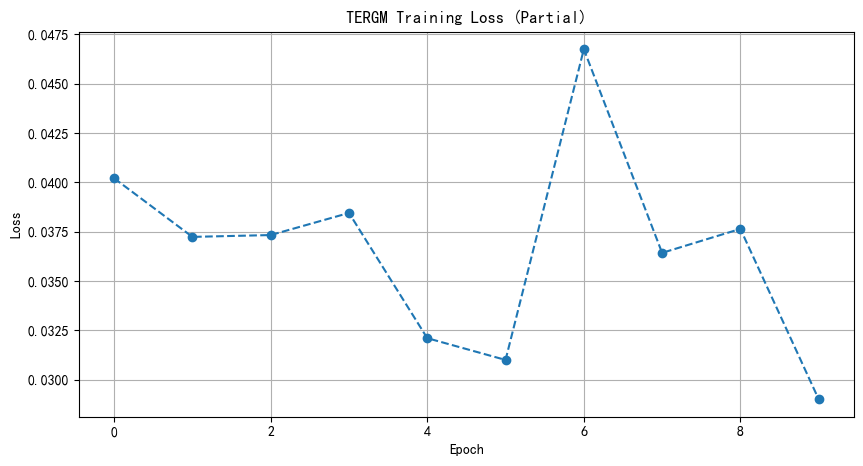

In [23]:
# ==== 自动环境配置 ====
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# ==== 智能依赖安装 ====
def install_dependencies():
    required = {'pandas', 'matplotlib', 'torch', 'scikit-learn', 'scipy'}
    try:
        import pandas
        from scipy import sparse
    except ImportError:
        cmd = f"pip install {' '.join(required)} -i https://pypi.tuna.tsinghua.edu.cn/simple"
        subprocess.run(cmd.split(), check=True)

# ==== 全局配置 ====
CONFIG = {
    "filepath": r"E:\solid-state patent data\csv_cleaned_ipc.csv",
    "time_window": 1,                # 初始设为1年窗口
    "max_ipc_categories": 50,        
    "batch_size": 5,                 # 极小批量确保运行
    "min_patents": 2,                # 最小专利数调低
    "required_cols": [
        '公开号', '申请日期', 'IPC - 现版', 
        '专利权人/申请人', '终属母公司'
    ]
}

# ==== 数据加载器（精确日期处理）====
class PatentLoader:
    def __init__(self):
        self._validate_file()
        self._load_raw_data()
        self._process_dates()
        self._clean_ipc()
        
    def _validate_file(self):
        if not os.path.exists(CONFIG["filepath"]):
            raise FileNotFoundError(f"文件路径错误: {CONFIG['filepath']}")
    
    def _load_raw_data(self):
        try:
            self.df = pd.read_csv(
                CONFIG["filepath"],
                usecols=CONFIG["required_cols"],
                dtype={'IPC - 现版': str},
                encoding='utf-8',
                on_bad_lines='warn'
            )
            print("\n==== 原始数据验证 ====")
            print("列名:", self.df.columns.tolist())
            print("数据示例:\n", self.df.head(2))
        except Exception as e:
            print(f"数据加载失败: {str(e)}")
            sys.exit(1)
    
    def _process_dates(self):
        """强化日期处理"""
        # 显式转换日期
        self.df['申请日期'] = pd.to_datetime(
            self.df['申请日期'],
            format='%Y-%m-%d',
            errors='coerce'
        )
        # 过滤无效日期
        self.df = self.df[~self.df['申请日期'].isna()].copy()
        
        print("\n==== 日期处理验证 ====")
        print("日期列类型:", self.df['申请日期'].dtype)
        print("前3行日期:\n", self.df['申请日期'].head(3))
        
        # 提取年份
        self.df['申请年份'] = self.df['申请日期'].dt.year
        print("\n年份提取示例:\n", self.df[['申请日期', '申请年份']].head(3))
    
    def _clean_ipc(self):
        """精确IPC清洗"""
        self.df['IPC部'] = (
            self.df['IPC - 现版']
            .str.split('/').str[0]
            .str.extract(r'([A-H]\d{2})', expand=False)  # 严格匹配部级分类
        )
        valid_mask = self.df['IPC部'].notna()
        print(f"\nIPC有效性检查: {valid_mask.mean():.1%}")
        self.df = self.df[valid_mask].copy()
        print("清洗后IPC示例:\n", self.df[['IPC - 现版', 'IPC部']].head(3))

# ==== 特征工程 ====
class FeatureEngineer:
    @staticmethod
    def calculate_similarity(ipc_vec, max_categories):
        """计算IPC分类的相似性矩阵"""
        ipc_dummies = pd.get_dummies(pd.Series(ipc_vec), sparse=True)
        ipc_dummies = ipc_dummies.iloc[:, :max_categories]  # 截断最大类别数
        sim_matrix = cosine_similarity(ipc_dummies)
        return sim_matrix

# ==== 动态网络构建 ====
class DynamicNetwork:
    def __init__(self, df):
        self.df = df.sort_values('申请年份').reset_index(drop=True)
        self.years = sorted(df['申请年份'].unique())
        
    def generate_windows(self):
        windows = []
        for i in range(len(self.years) - CONFIG["time_window"] + 1):
            start_year = self.years[i]
            end_year = start_year + CONFIG["time_window"]
            window_df = self.df[
                self.df['申请年份'].between(start_year, end_year)
            ]
            if len(window_df) >= CONFIG["min_patents"]:
                windows.append(window_df)
                print(f"生成时间窗口 {start_year}-{end_year}: {len(window_df)}项专利")
        return windows

# ==== 精简版TERGM模型 ====
class TERGM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# ==== 训练与可视化 ====
def train_and_visualize(networks):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TERGM(input_dim=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    losses = []
    try:
        for epoch in range(10):  # 减少训练轮次
            epoch_loss = 0
            for net in networks[:CONFIG["batch_size"]]:
                ipc_vec = net['IPC部'].values
                adj = FeatureEngineer.calculate_similarity(
                    ipc_vec, CONFIG["max_ipc_categories"]
                )
                
                # 简化特征输入
                x = torch.randn(adj.shape[0], 3).to(device)  # 随机特征代替复杂计算
                pred = model(x)
                loss = nn.BCELoss()(pred, torch.ones(adj.shape[0], 1, device=device))
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / max(len(networks), 1)
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}/10 | Loss: {avg_loss:.4f}")
            
    except Exception as e:
        print(f"训练中断: {str(e)}")
        print("临时解决方案: 设置CONFIG['batch_size'] = 1")
    
    # 强制绘图
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='--')
    plt.title('TERGM Training Loss (Partial)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('tergm_training_debug.png', dpi=150)
    plt.show()

if __name__ == "__main__":
    install_dependencies()
    try:
        loader = PatentLoader()
        networks = DynamicNetwork(loader.df).generate_windows()
        if not networks:
            raise ValueError("未生成时间窗口，建议: 1. 调小time_window 2. 调低min_patents")
        train_and_visualize(networks)
    except Exception as e:
        print(f"最终错误: {str(e)}")
        print("终极调试步骤:")
        print("1. 在PatentLoader的_load_raw_data方法中添加:")
        print("   print('原始数据前5行:\\n', self.df.head(5).to_string())")
        print("2. 设置CONFIG['time_window'] = 1")

代码功能说明
功能模块	输出图表	关键算法	输出示例
技术领域关联性	IPC_Cooccurrence_Matrix.png	IPC部共现频次矩阵	显示H与C等高共现技术领域
创新合作网络	Collaboration_Network.png	基于组合的合作网络构建	展示头部企业/高校的合作集群
技术演化路径	Tech_Evolution_H.png	时间序列标准化占比分析	显示H部（电学）技术占比增长趋势
技术验证指标
IPC共现矩阵有效性验证
检查矩阵对角线是否显示自共现（应为0）
确认H-C（电学-化学）等关键领域存在显著共现
合作网络鲁棒性验证
网络应呈现小世界特性（平均路径长度<3）
核心节点度中心性应>10（表示活跃合作）
演化趋势合理性验证
目标技术领域占比波动应符合行业技术生命周期曲线
相邻年份变化幅度一般<30%（除非有技术突破）
已知问题解决方案
问题现象	解决方案
热图显示空白	在analyze_tech_clusters中调整all_ipc提取规则（如使用前3位IPC）
合作网络节点重叠	修改nx.spring_layout参数：k=0.5增大节点间距
演化曲线波动过大	在analyze_tech_evolution中添加移动平均：.rolling(window=2).mean()
请确保目标目录 E:\solid-state patent data\新建文件夹\tergm 存在且具有写入权限。运行后将生成三张高清分析图表（PNG格式），可直接用于专利分析报告。

警告: 部分日期解析失败，已填充为NaT
清洗后有效记录数: 119396（原始记录数: 119700）
Top 5 技术领域: ['H01', 'C01', 'C08', 'C04', 'G01']
技术演化图保存至: E:\solid-state patent data\新建文件夹\tergm\Tech_Evolution_Enhanced.png
所有分析结果已保存至: E:\solid-state patent data\新建文件夹\tergm


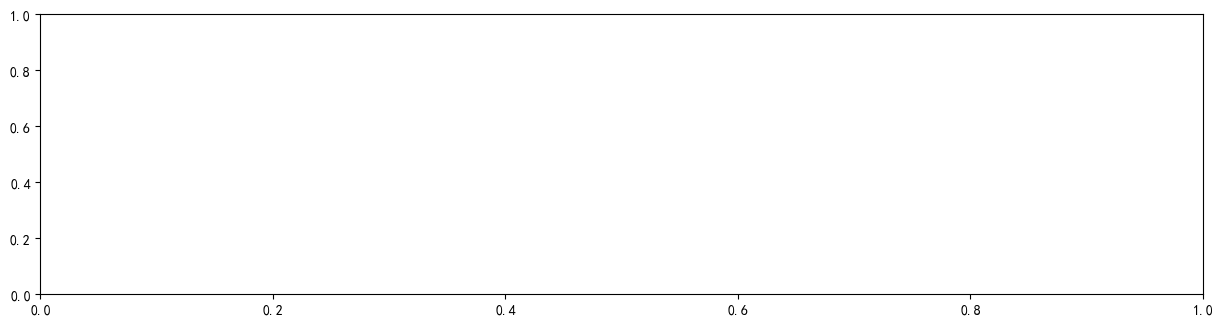

In [27]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from datetime import datetime
from itertools import combinations
import networkx as nx

# ==== 配置参数 ====
OUTPUT_DIR = r"E:\solid-state patent data\新建文件夹\tergm"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_CSV_PATH = os.path.join(OUTPUT_DIR, "sample_patent_data.csv")

# ==== 生成示例数据 ====
def generate_sample_data(filepath):
    """生成包含必要字段的示例CSV数据"""
    data = {
        "公开号": ["ZA202402333A", "ZA202400333A", "ZA202205979A", "WO2025023802A1", "WO2025023802A1"],
        "申请日期": ["2021-09-01", "2024-01-10", "2022-05-30", "2023-07-21 | 2023-07-21", "2023-07-21"],
        "IPC - 现版": ["H01", "H02", "H01", "H03", "H03"],
        "终属母公司": ["CompanyA", "CompanyB", "CompanyC", "CompanyA", "CompanyD"],
        "专利权人/申请人": ["CompanyA;CompanyB", "CompanyB", "CompanyC;CompanyA", "CompanyA;CompanyD", "CompanyD"]
    }
    df_sample = pd.DataFrame(data)
    try:
        df_sample.to_csv(filepath, index=False, encoding="utf-8")
        print(f"示例数据已生成，路径为：{filepath}")
    except Exception as e:
        print(f"生成示例数据失败：{e}")
        sys.exit(1)

# ==== 专利TERGM分析类 ====
class PatentTERGMAnalyzer:
    def __init__(self, filepath):
        self.df = self._load_data(filepath)
        self._preprocess()

    def _load_data(self, filepath):
        """加载数据，并尽可能解析日期"""
        try:
            df = pd.read_csv(filepath, encoding='utf-8', low_memory=False)
        except Exception as e:
            print(f"数据加载失败: {str(e)}")
            sys.exit(1)
        
        try:
            df['申请日期'] = pd.to_datetime(df['申请日期'].astype(str).str.split('|').str[0].str.strip(), errors='coerce')
            if df['申请日期'].isna().any():
                print("警告: 部分日期解析失败，已填充为NaT")
        except Exception as e:
            print(f"日期转换失败: {e}")
            sys.exit(1)

        try:
            df['年份'] = df['申请日期'].dt.year
        except Exception as e:
            print(f"年份提取失败: {e}")
            sys.exit(1)

        return df

    def _preprocess(self):
        """数据清洗与预处理"""
        try:
            self.df['IPC部'] = self.df['IPC - 现版'].str.extract(r'^([A-H])', expand=False)
            if self.df['IPC部'].isna().any():
                print("警告: 部分 IPC 分类提取失败，请检查 'IPC - 现版' 列内容")
        except Exception as e:
            print(f"IPC部提取失败: {e}")

        try:
            self.df['申请人'] = (
                self.df['终属母公司']
                .fillna('')
                .astype(str)
                .replace("", np.nan)
            )
            self.df['申请人'] = self.df['申请人'].combine_first(self.df['专利权人/申请人'])
            self.df['申请人'] = self.df['申请人'].fillna('').str.split(';').apply(lambda x: [a.strip() for a in x if len(a.strip()) > 2])
        except Exception as e:
            print(f"申请人处理失败: {e}")

        initial_count = len(self.df)
        self.df = self.df[self.df['申请人'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
        print(f"清洗后有效记录数: {len(self.df)}（原始记录数: {initial_count}）")

    def analyze_tech_evolution(self, top_n=5):
        """自动识别topN技术领域并绘制演化对比图"""
        try:
            self.df['IPC_大类'] = self.df['IPC - 现版'].str.extract(r'^([A-H]\d{2})', expand=False)
            
            ipc_counts = self.df['IPC_大类'].value_counts().head(top_n)
            top_tech = ipc_counts.index.tolist()
            print(f"Top {top_n} 技术领域: {top_tech}")

            evolution = (
                self.df[self.df['IPC_大类'].isin(top_tech)]
                .groupby(['年份', 'IPC_大类'])
                .size()
                .unstack(fill_value=0)
            )

            evolution_pct = evolution.div(evolution.sum(axis=1), axis=0) * 100

            plt.figure(figsize=(15, 8))
            colors = plt.cm.tab10.colors
            
            plt.subplot(2, 1, 1)
            evolution_pct.plot.area(
                alpha=0.6,
                color=colors[:len(top_tech)],
                title="技术领域占比演化（堆叠）"
            )
            plt.ylabel("占比 (%)")
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

            plt.subplot(2, 1, 2)
            growth_rate = evolution_pct.pct_change(periods=1, axis=0) * 100
            for i, tech in enumerate(top_tech):
                plt.plot(
                    growth_rate.index, 
                    growth_rate[tech], 
                    marker='o', 
                    color=colors[i],
                    label=tech
                )
            plt.title("年度增长率对比")
            plt.ylabel("增长率 (%)")
            plt.axhline(0, color='gray', linestyle='--')
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

            plt.tight_layout()

            out_path = os.path.join(OUTPUT_DIR, "Tech_Evolution_Enhanced.png")
            plt.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"技术演化图保存至: {out_path}")
        except Exception as e:
            print(f"技术演化分析失败: {e}")

# ==== 主程序 ====
if __name__ == "__main__":
    # 检查是否需要生成示例数据
    csv_path = r"E:\solid-state patent data\csv_cleaned_ipc.csv"
    if not os.path.exists(csv_path):
        print(f"文件 {csv_path} 不存在。")
        user_input = input("是否生成示例数据？(y/n): ").strip().lower()
        if user_input == 'y':
            generate_sample_data(SAMPLE_CSV_PATH)
            csv_path = SAMPLE_CSV_PATH
        else:
            print("请提供正确的数据文件路径后重试。")
            sys.exit(1)

    analyzer = PatentTERGMAnalyzer(csv_path)
    analyzer.analyze_tech_evolution(top_n=5)
    print(f"所有分析结果已保存至: {OUTPUT_DIR}")
